In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(23) #kallisti

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

## Low Rank Approximations of Rectangle Data

In [2]:
rectangle = pd.read_csv("rectangle_data.csv")

In [3]:
rectangle.head(5)

,width,height,area,perimeter
0,8,6,48,28
1,2,4,8,12
2,1,3,3,8
3,9,3,27,24
4,9,8,72,34


In [4]:
colnames = list(rectangle.columns)

Suppose we our area and perimeter measurements are slightly noisy.

In [5]:
rectangle_noisy = rectangle.copy()
rectangle_noisy["perimeter"] += np.random.normal(loc = 0, scale = 0.01, size = len(rectangle_noisy["perimeter"]))
rectangle_noisy["area"] += np.random.normal(loc = 0, scale = 0.01, size = len(rectangle_noisy["area"]))
rectangle_noisy.head(5)

,width,height,area,perimeter
0,8,6,47.986671,28.006670
1,2,4,8.016374,12.000258
2,1,3,2.991771,7.992224
3,9,3,26.984019,24.009486
4,9,8,72.002265,34.007017


In [6]:
u, s, vt = np.linalg.svd(rectangle_noisy, full_matrices = False)

Even on this noisy data, we can recover the exact measurements by multiplying $U \Sigma V^T$.

In [7]:
vt

array([[-1.46434778e-01, -1.29940333e-01, -8.10009684e-01,
        -5.52771814e-01],
       [-1.92749729e-01, -1.89073082e-01,  5.86362967e-01,
        -7.63725986e-01],
       [-7.04883162e-01,  7.09229421e-01,  7.92356223e-03,
         8.40082694e-03],
       [ 6.66741424e-01,  6.66603712e-01, -1.06479316e-05,
        -3.33309714e-01]])

In [8]:
pd.DataFrame((u @ np.diag(s) @ vt)[0:5, :]).head(5)

,0,1,2,3
0,8.0,6.0,47.986671,28.006670
1,2.0,4.0,8.016374,12.000258
2,1.0,3.0,2.991771,7.992224
3,9.0,3.0,26.984019,24.009486
4,9.0,8.0,72.002265,34.007017


Let's take a look at the singular values:

In [9]:
s

array([3.62934601e+02, 6.30021119e+01, 2.56544077e+01, 3.14825540e-02])

Despite not being zero, we can nevertheless again eliminate the last column (dimension) of $U$, last singular value from $\Sigma$ and last row (operation) from $V^T$. We see that we get back reasonable answers, though they're a little off.

In [10]:
pd.DataFrame((u[:, :-1] @ np.diag(s[:-1]) @ vt[:-1, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,8.001235,6.001235,47.986671,28.006052
1,1.999994,3.999994,8.016374,12.000261
2,0.998243,2.998244,2.991771,7.993102
3,9.001599,3.001599,26.984019,24.008687
4,9.001422,8.001422,72.002265,34.006306


This is what is known as a "low rank approximation" of the data. Specifically, this is a rank 3 approximation since we're using 3 of the available 4 dimensions. Since the noise was small, this rank 3 approximation is good. 

As a warmup to the rest of lecture, let's see what the rank 2 approximation looks like. 

Note: In the code below, I've specified which rows/columns that I do want rather than the ones I don't want. That is, instead of writing `u[:, :-2]`, I've written `u[:, 0:2]`.

In [11]:
pd.DataFrame((u[:, 0:2] @ np.diag(s[0:2]) @ vt[0:2, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,7.459755,6.546054,47.992758,28.012506
1,3.121802,2.871268,8.003764,11.986892
2,2.065191,1.924717,2.979777,7.980386
3,6.322514,5.697203,27.014134,24.040616
4,9.132593,7.869443,72.000791,34.004742


This code is getting a little hard to read, so let's write a function that computes the rank k approximation of a given DataFrame.

In [12]:
def compute_rank_k_approximation(data, k):
    u, s, vt = np.linalg.svd(data, full_matrices = False)
    return pd.DataFrame(u[:, 0:k] @ np.diag(s[0:k]) @ vt[0:k, :], columns = data.columns)

pd.DataFrame(compute_rank_k_approximation(rectangle_noisy, 2)).head(5)

,width,height,area,perimeter
0,7.459755,6.546054,47.992758,28.012506
1,3.121802,2.871268,8.003764,11.986892
2,2.065191,1.924717,2.979777,7.980386
3,6.322514,5.697203,27.014134,24.040616
4,9.132593,7.869443,72.000791,34.004742


We can even look at the rank 1 approximation. 

In [13]:
compute_rank_k_approximation(rectangle_noisy, 1).head(5)

,width,height,area,perimeter
0,8.244584,7.315912,45.605235,31.122206
1,2.041209,1.811287,11.291029,7.705294
2,1.080322,0.958634,5.975842,4.078071
3,5.394191,4.786588,29.838179,20.362355
4,11.638356,10.327409,64.378021,43.933247


In effect, what the SVD process has done is figured out a way to rebuild an approximation of our entire 4D matrix using only 1 column of data. This might seem somewhat shocking.

In [14]:
pd.DataFrame((u[:, 0:1] @ np.diag(s[0:1]) @ vt[0:1, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,8.244584,7.315912,45.605235,31.122206
1,2.041209,1.811287,11.291029,7.705294
2,1.080322,0.958634,5.975842,4.078071
3,5.394191,4.786588,29.838179,20.362355
4,11.638356,10.327409,64.378021,43.933247


In [15]:
u, s, vt = np.linalg.svd(rectangle, full_matrices = False)
compute_rank_k_approximation(rectangle_noisy, 1).head(5)

,width,height,area,perimeter
0,8.244584,7.315912,45.605235,31.122206
1,2.041209,1.811287,11.291029,7.705294
2,1.080322,0.958634,5.975842,4.078071
3,5.394191,4.786588,29.838179,20.362355
4,11.638356,10.327409,64.378021,43.933247


## Rank 1 Approximation of 2D Data, Data Centering

In [16]:
# Downloads from https://www.gapminder.org/data/
cm_path = 'child_mortality_0_5_year_olds_dying_per_1000_born.csv'
fe_path = 'children_per_woman_total_fertility.csv'
cm = pd.read_csv(cm_path).set_index('country')['2017'].to_frame()/10
fe = pd.read_csv(fe_path).set_index('country')['2017'].to_frame()
child_data = cm.merge(fe, left_index=True, right_index=True).dropna()
child_data.columns = ['mortality', 'fertility']
child_data.head()

,mortality,fertility
country,,
Afghanistan,6.820,4.48
Albania,1.330,1.71
Algeria,2.390,2.71
Angola,8.310,5.62
Antigua and Barbuda,0.816,2.04


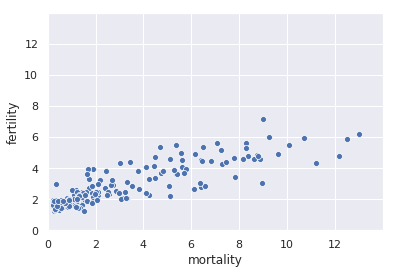

In [17]:
def scatter14(data):
    sns.scatterplot('mortality', 'fertility', data=data)
    plt.xlim([0, 14])
    plt.ylim([0, 14])
    plt.xticks(np.arange(0, 14, 2))
    plt.yticks(np.arange(0, 14, 2))    
    
scatter14(child_data)

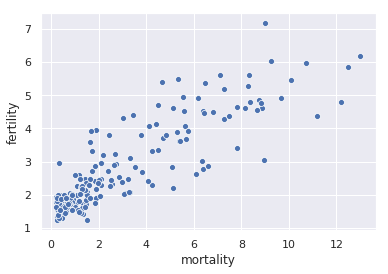

In [18]:
sns.scatterplot('mortality', 'fertility', data=child_data)

In [19]:
u, s, vt = np.linalg.svd(child_data, full_matrices = False)

In [20]:
child_data_reconstructed = pd.DataFrame(u @ np.diag(s) @ vt, columns = ["mortality", "fertility"], index=child_data.index)

As we'd expect, the product of $U$, $\Sigma$, and $V^T$ recovers the original data perfectly.

In [21]:
child_data_reconstructed.head(5)

,mortality,fertility
country,,
Afghanistan,6.820,4.48
Albania,1.330,1.71
Algeria,2.390,2.71
Angola,8.310,5.62
Antigua and Barbuda,0.816,2.04


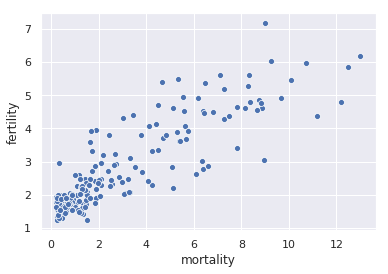

In [22]:
sns.scatterplot('mortality', 'fertility', data=child_data)

What happens if we throw away a column of $U$, a singular value from $\Sigma$, and a row from $V^T$? In this case we end up with the "rank 1 approximation" of the data.

Looking at the data, we see that it does a surprisingly good job.

In [23]:
#child_data_rank_1_approximation = pd.DataFrame(u[:, :-1] @ np.diag(s[:-1]) @ vt[:-1, :], columns = ["mortality", "fertility"], index=child_data.index)

child_data_rank_1_approximation = compute_rank_k_approximation(child_data, 1)
child_data_rank_1_approximation.head(5)

,mortality,fertility
0,6.694067,4.660869
1,1.697627,1.182004
2,2.880467,2.005579
3,8.232160,5.731795
4,1.506198,1.048719


By plotting the data in a 2D space, we can see what's going on. We're simply getting the original data projected on to some 1 dimensional subspace.

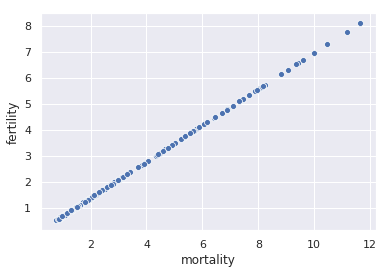

In [24]:
sns.scatterplot('mortality', 'fertility', data=child_data_rank_1_approximation)

There's one significant issue with our projection, which we can see by plotting both the original data and our reconstruction on the same axis. The issue is that the projection goes through the origin but our data has a non-zero y-intercept.

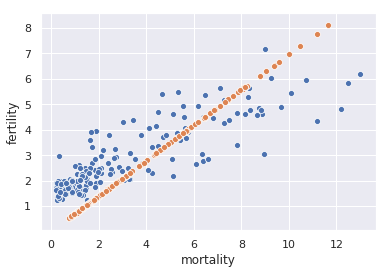

In [25]:
sns.scatterplot('mortality', 'fertility', data=child_data)
sns.scatterplot('mortality', 'fertility', data=child_data_rank_1_approximation)

While this y-intercept misalignment isn't terrible here, it can be really bad. For example, consider the 2D dataset below (from our body measurements dataset from the previous lecture).

In [26]:
#http://jse.amstat.org/datasets/fat.txt
body_data = pd.read_fwf("fat.dat.txt", colspecs = [(9, 13), (17, 21), (23, 29), (35, 37),
                                             (39, 45), (48, 53), (57, 61), (64, 69),
                                             (73, 77), (80, 85), (88, 93), (96, 101),
                                             (105, 109), (113, 117), (121, 125), (129, 133),
                                             (137, 141), (145, 149)], 
                  
                  
                  header=None, names = ["% brozek fat", "% siri fat", "density", "age", 
                                       "weight", "height", "adiposity", "fat free weight",
                                       "neck", "chest", "abdomen", "hip", "thigh",
                                       "knee", "ankle", "bicep", "forearm",
                                       "wrist"])
#body_data = body_data.drop(41) #drop the weird record
body_data.head()

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [27]:
density_and_abdomen = body_data[["density", "abdomen"]]
density_and_abdomen.head(5)

,density,abdomen
0,1.0708,85.2
1,1.0853,83.0
2,1.0414,87.9
3,1.0751,86.4
4,1.0340,100.0


If we look at the data, the rank 1 approximation looks at least vaguely sane from the table. 

In [28]:
density_and_abdomen_rank_1_approximation = compute_rank_k_approximation(density_and_abdomen, 1)
density_and_abdomen_rank_1_approximation.head(5)

,density,abdomen
0,0.957134,85.201277
1,0.932425,83.001717
2,0.987458,87.900606
3,0.970613,86.401174
4,1.123369,99.998996


But if we plot on 2D axes, we'll see that things are very wrong.

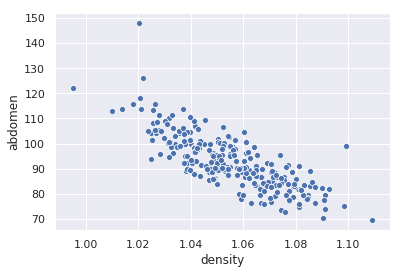

In [29]:
sns.scatterplot(x="density", y="abdomen", data=body_data)

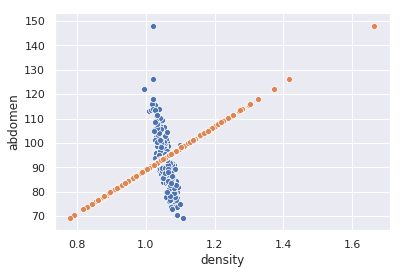

In [30]:
density_and_abdomen_rank_1_approximation = compute_rank_k_approximation(density_and_abdomen, 1)
sns.scatterplot(x="density", y="abdomen", data=body_data)
sns.scatterplot(x="density", y="abdomen", data=density_and_abdomen_rank_1_approximation);

Since the subspace that we're projecting on to is off and to the right, we end up with a bizarre result where our rank 1 approximation believes that density increases with abdomen size, even though the data shows the opposite.

To fix this issue, we should always start the SVD process by zero-centering our data. That is, for each column, we should subtract the mean of that column.

In [31]:
np.mean(density_and_abdomen, axis = 0)

density     1.055574
abdomen    92.555952
dtype: float64

In [32]:
density_and_abdomen_centered = density_and_abdomen - np.mean(density_and_abdomen, axis = 0)
density_and_abdomen_centered.head(5)

,density,abdomen
0,0.015226,-7.355952
1,0.029726,-9.555952
2,-0.014174,-4.655952
3,0.019526,-6.155952
4,-0.021574,7.444048


Now when we do the approximation, things work much better.

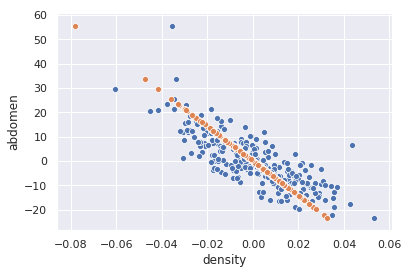

In [33]:
density_and_abdomen_centered_rank_1_approximation = compute_rank_k_approximation(density_and_abdomen_centered, 1)
sns.scatterplot(x="density", y="abdomen", data=density_and_abdomen_centered)
sns.scatterplot(x="density", y="abdomen", data=density_and_abdomen_centered_rank_1_approximation);

### Interpreting Principal Components

Let's revisit our child mortality and maternal fertility data from before.

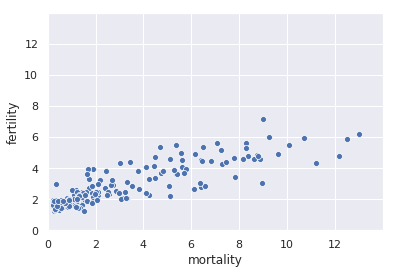

In [34]:
sns.scatterplot(data = child_data, x = "mortality", y= "fertility")
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));

Since we're going to be doing SVD, let's make sure to center our data first.

In [35]:
np.mean(child_data, axis = 0)

mortality    3.034590
fertility    2.775956
dtype: float64

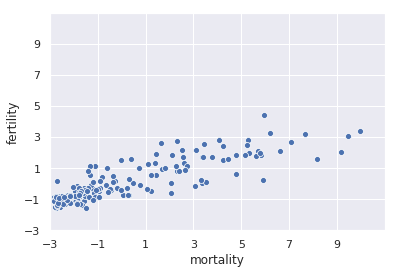

In [36]:
child_means = np.mean(child_data, axis = 0)
child_data_centered = child_data - child_means
sns.scatterplot(data = child_data_centered, x = "mortality", y= "fertility")


plt.xlim([-3, 11])
plt.ylim([-3, 11])
plt.xticks(np.arange(-3, 11, 2))
plt.yticks(np.arange(-3, 11, 2));
plt.gcf().savefig("mortality_fertility_centered.png", dpi=300, bbox_inches="tight")

Tie in with the manual computation slides.

## PCA vs. Linear Regression

Now we'll finally turn to trying to understand what the principle components and the low rank approximations actually mean!

Returning to our child mortality data from before, if we zero-center the child data, we see get back a better result. Note that we have to add back in the mean of each column to get things back into the right units.

In [37]:
means = np.mean(child_data, axis = 0)
child_data_centered = child_data - np.mean(child_data, axis = 0)
child_data_rank_1_approximation = compute_rank_k_approximation(child_data_centered, 1) + means

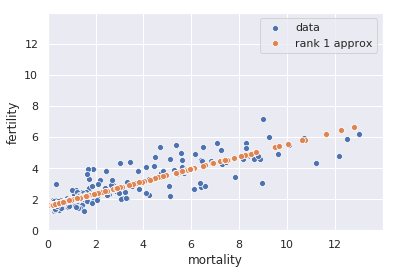

In [38]:
sns.scatterplot('mortality', 'fertility', data=child_data)
sns.scatterplot('mortality', 'fertility', data=child_data_rank_1_approximation)
plt.legend(['data', 'rank 1 approx'])
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));

We can also give our rank 1 approximation as a line, showing the 1D subspace (in black) that our data is being projected onto.

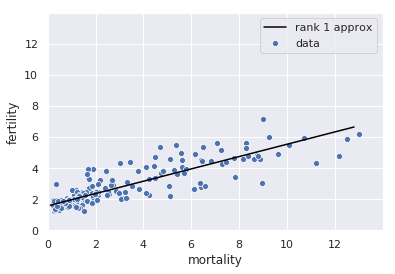

In [39]:
sns.scatterplot('mortality', 'fertility', data=child_data)
sns.lineplot('mortality', 'fertility', data=child_data_rank_1_approximation, color='black')
plt.legend(['rank 1 approx', 'data']);
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));

This plot probably brings to mind linear regression from Data 8. But PCA is NOT the same thing linear regression. Let's plot the regression lines for this data for comparison. Recall that the regression line gives us, e.g. the best possible linear prediction of the fertility given the mortality.

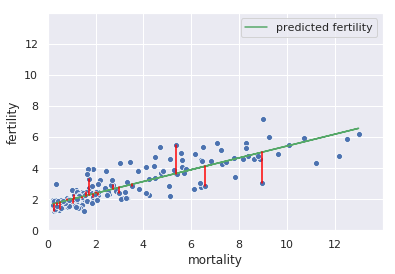

In [40]:
x, y = child_data['mortality'], child_data['fertility']
slope_x, intercept_x = np.polyfit(x, y, 1) # simple linear regression

scatter14(child_data)

plt.plot(x, slope_x * x + intercept_x, c = 'g')
for _, row in child_data.sample(20).iterrows():
    tx, ty = row['mortality'], row['fertility']
    plt.plot([tx, tx], [slope_x * tx + intercept_x, ty], c='red')
    
plt.legend(['predicted fertility']);

In the plot above, the green regression line given minimizes the sum of the squared errors, given as red vertical lines.

We could also do the opposite thing, and try to predict fertility from mortality.

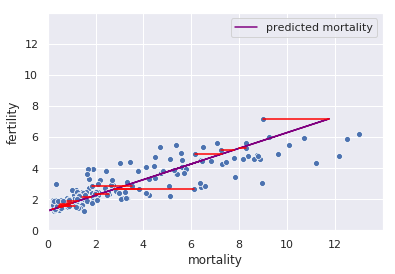

In [41]:
x, y = child_data['mortality'], child_data['fertility']
slope_y, intercept_y = np.polyfit(y, x, 1) # simple linear regression

scatter14(child_data)

plt.plot(slope_y * y + intercept_y, y, c = 'purple')
for _, row in child_data.sample(20).iterrows():
    tx, ty = row['mortality'], row['fertility']
    plt.plot([tx, slope_y * ty + intercept_y], [ty, ty], c='red')
    
plt.legend(['predicted mortality']);

In the plot above, the green regression line given minimizes the sum of the squared errors, given as red horizontal lines.

Plotting the two regression lines and the 1D subspace chosen by PCA, we see that all 3 are distinct!

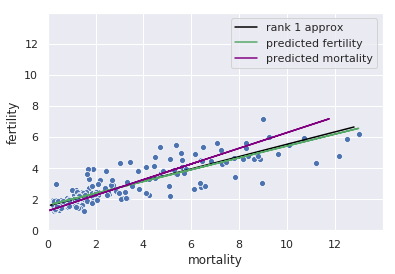

In [42]:
sns.lineplot('mortality', 'fertility', data=child_data_rank_1_approximation, color="black")
plt.plot(x, slope_x * x + intercept_x, c = 'g')
plt.plot(slope_y * y + intercept_y, y, c = 'purple');
sns.scatterplot('mortality', 'fertility', data=child_data)
plt.legend(['rank 1 approx', 'predicted fertility', 'predicted mortality'])
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));

Given that the green line minimizes the "vertical error" and the purple line minimizes the "horizontal error". You might wonder what the black line minimizes. It turns out, it minimizes the "diagonal" error, i.e. the error in the direction perpendicular to itself.

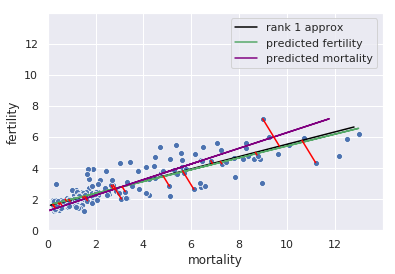

In [43]:
sns.lineplot('mortality', 'fertility', data=child_data_rank_1_approximation, color="black")
plt.plot(x, slope_x * x + intercept_x, c = 'g')
plt.plot(slope_y * y + intercept_y, y, c = 'purple');
sns.scatterplot('mortality', 'fertility', data=child_data)

for idx, tdata in child_data.reset_index().sample(20).iterrows():
    tx = tdata["mortality"]
    ty = tdata["fertility"]
    tx_projected = child_data_rank_1_approximation.iloc[idx, 0]
    ty_projected = child_data_rank_1_approximation.iloc[idx, 1]
    plt.plot([tx, tx_projected], [ty, ty_projected], c='red')
    
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));
plt.legend(['rank 1 approx', 'predicted fertility', 'predicted mortality']);

The function in the following cell makes it easy to make similar plots for whatever dataset you might be interested in.

In [44]:
def plot_x_regression_y_regression_1d_approximation(data): 
    xname = data.columns[0]
    yname = data.columns[1]
    
    x, y = data[xname], data[yname]
    slope_x, intercept_x = np.polyfit(x, y, 1) # simple linear regression
    
    x, y = data[xname], data[yname]
    slope_y, intercept_y = np.polyfit(y, x, 1) # simple linear regression
    
    means = np.mean(data, axis = 0)
    rank_1_approximation = compute_rank_k_approximation(data - means, 1) + means
    
    sns.lineplot(x=xname, y=yname, data=rank_1_approximation, color="black")
    plt.plot(x, slope_x * x + intercept_x, c = 'g')
    plt.plot(slope_y * y + intercept_y, y, c = 'purple');
    sns.scatterplot(xname, yname, data=data)
    
   
    for idx, tdata in data.reset_index().sample(20).iterrows():
        tx = tdata[xname]
        ty = tdata[yname]
        
        tx_projected = rank_1_approximation.iloc[idx, 0]
        ty_projected = rank_1_approximation.iloc[idx, 1]
        plt.plot([tx, tx_projected], [ty, ty_projected], c='red') 
    
    plt.legend(['1D PCA Subspace', 'predicted ' + xname, 'predicted ' + yname])

/home/hug/miniconda2/envs/data100/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


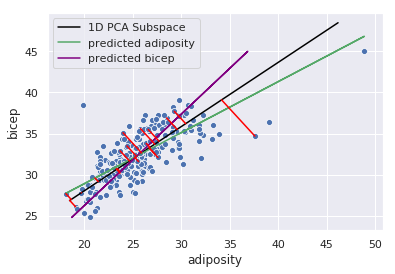

In [45]:
plot_x_regression_y_regression_1d_approximation(body_data.drop(41)[["adiposity", "bicep"]])

## Principal Components and Singular Values

###  Singular Values and Variance

In [46]:
rectangle_centered = rectangle - np.mean(rectangle, axis = 0)

In [47]:
np.var(rectangle_centered)

width          7.6891
height         5.3475
area         338.7316
perimeter     50.7904
dtype: float64

In [48]:
sum(np.var(rectangle_centered))

402.5586000000002

In [49]:
u, s, vt = np.linalg.svd(rectangle_centered, full_matrices = False)

In [50]:
u[0:5, :]

array([[-0.1339099 ,  0.00592996,  0.03473374, -0.29683623],
       [ 0.08635418, -0.07951453,  0.01494809,  0.71147825],
       [ 0.11776646, -0.12896256,  0.08577428, -0.06531837],
       [-0.02727392,  0.1831771 ,  0.01089507, -0.03105541],
       [-0.258806  , -0.09429499,  0.09027015, -0.03281766]])

In [51]:
np.diag(s)

array([[1.97388075e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.74346257e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.32626119e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.22425467e-15]])

In [52]:
s**2/rectangle_centered.shape[0]

array([3.89620522e+02, 7.52658687e+00, 5.41149115e+00, 8.50868742e-31])

In [53]:
sum(s**2/rectangle_centered.shape[0])

402.55860000000007

## Practical PCA

Let's now step back and try to use PCA on our body measurement and congressional voting datasets.

In [54]:
body_data.head(5)

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [55]:
u, s, vt = np.linalg.svd(body_data, full_matrices = False)

We see that some of our singular values capture more variance than others.

In [56]:
s

array([5.02052705e+03, 2.62085056e+02, 2.54543432e+02, 1.41812428e+02,
       5.98783810e+01, 5.29106976e+01, 4.16567900e+01, 3.12823306e+01,
       2.60271725e+01, 2.44919558e+01, 2.21128215e+01, 2.05280695e+01,
       1.86667123e+01, 1.67184654e+01, 1.24277631e+01, 7.79276210e+00,
       1.97067950e+00, 2.72193414e-01])

Or we can compute the fraction of the variance captured by each principal component. The result seems shocking at first, as our data appears to be effectively rank 1.

In [57]:
np.round(s**2 / sum(s**2), 2)

array([0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

This seems absurd, as clearly there are several variables that we expect to be show significant variation independent of each other, e.g. weight, height, and age. If this happens to you, it's probably because you forgot to center your data!

In [58]:
body_data_centered = body_data - np.mean(body_data, axis = 0)
body_data_centered.head(5)

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,-6.338492,-6.850794,0.015226,-21.884921,-24.674405,-2.39881,-1.736905,-8.813889,-1.792063,-7.724206,-7.355952,-5.404762,-0.405952,-1.290476,-1.202381,-0.273413,-1.263889,-1.129762
1,-12.038492,-13.050794,0.029726,-22.884921,-5.674405,2.10119,-2.036905,17.586111,0.507937,-7.224206,-9.555952,-1.204762,-0.705952,-1.290476,0.297619,-1.773413,0.236111,-0.029762
2,5.661508,6.149206,-0.014174,-22.884921,-24.924405,-3.89881,-0.736905,-27.713889,-3.992063,-5.024206,-4.655952,-0.704762,0.194048,0.309524,0.897619,-3.473413,-3.463889,-1.629762
3,-8.038492,-8.750794,0.019526,-18.884921,5.825595,2.10119,-0.536905,20.986111,-0.592063,0.975794,-6.155952,1.295238,0.694048,-1.290476,-0.302381,0.126587,0.736111,-0.029762
4,8.861508,9.549206,-0.021574,-20.884921,5.325595,1.10119,0.163095,-10.613889,-3.592063,-3.524206,7.444048,1.995238,3.794048,3.609524,0.897619,-0.073413,-0.963889,-0.529762


In [59]:
u, s, vt = np.linalg.svd(body_data_centered, full_matrices = False)

This time, we see that the top singular value is no longer as dominant.

In [60]:
s

array([5.86347268e+02, 2.61819089e+02, 1.67113835e+02, 5.99708077e+01,
       5.33302486e+01, 4.22415004e+01, 3.48011060e+01, 2.92855997e+01,
       2.55426169e+01, 2.39181665e+01, 2.08396531e+01, 2.04736098e+01,
       1.85404097e+01, 1.62788697e+01, 1.23779482e+01, 7.72010337e+00,
       1.95363897e+00, 4.48706065e-02])

Looking now at the fraction of the variance captured by each principal component, we see that the top 2 or 3 principal components capture quite a lot of the variance.

In [61]:
np.round(s**2 / sum(s**2), 2)

array([0.76, 0.15, 0.06, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

We can also show this in the form of what is usually called a "scree plot".

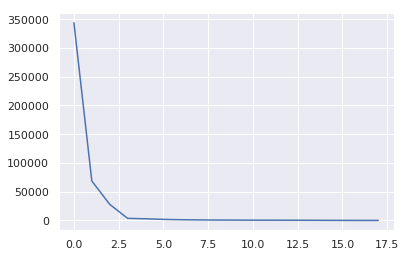

In [62]:
plt.plot(s**2);

Thus, we expect that if we were to do a rank 3 approximation, we should get back data that's pretty close to where we started, as just those 3 dimensions capture 97% of the variance.

In [63]:
body_data_rank_3_approximation = compute_rank_k_approximation(body_data_centered, 3) +  np.mean(body_data, axis = 0)
body_data_rank_3_approximation.head(5)

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,13.732084,13.499443,1.067647,23.406671,155.524219,69.685017,22.382014,134.660313,35.750451,92.404761,81.663261,95.367676,57.832005,36.807149,22.471102,30.513755,27.871398,17.221299
1,6.949481,6.177696,1.084653,22.136786,173.262498,72.818426,22.848506,161.108343,37.281215,94.764794,81.952662,98.256188,59.629903,38.251464,23.494178,31.990484,28.799694,18.014750
2,24.388640,24.995400,1.041272,22.012988,155.515375,66.961498,24.013328,115.107332,35.327536,94.623409,87.487254,96.824325,59.191562,36.564650,22.049234,30.526265,27.727128,16.734867
3,10.535884,10.053321,1.076052,26.287526,185.315285,72.840641,24.486712,164.078362,38.187196,98.649630,87.304458,101.045858,61.263963,39.095345,23.826619,32.953935,29.261160,18.327856
4,27.324362,28.164091,1.034484,23.983222,184.352508,68.475540,26.973751,132.523943,37.446408,101.921954,96.240973,103.147363,63.286670,38.642499,23.123048,32.896046,28.991277,17.530191


In [64]:
body_data.head(5)

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


One very interesting thing we can do is try to plot the principal components themselves. In this case, let's plot only the first two.

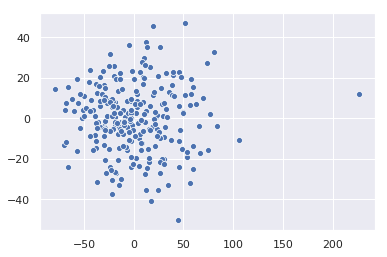

In [65]:
u, s, vt = np.linalg.svd(body_data_centered, full_matrices = False)
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1]);

In [66]:
np.argmax(pcs[:, 0])

38

In [67]:
body_data.iloc[38, :]

% brozek fat        33.8000
% siri fat          35.2000
density              1.0202
age                 46.0000
weight             363.1500
height              72.2500
adiposity           48.9000
fat free weight    240.5000
neck                51.2000
chest              136.2000
abdomen            148.1000
hip                147.7000
thigh               87.3000
knee                49.1000
ankle               29.6000
bicep               45.0000
forearm             29.0000
wrist               21.4000
Name: 38, dtype: float64

## Election Data

In [70]:
from ds100_utils import fetch_and_cache
import yaml
from datetime import datetime


base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
legislators_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + legislators_path, legislators_path)
legislators_data = yaml.load(open(f))

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs.head(3)

Using cached version that was downloaded (UTC): Thu Oct  3 09:10:09 2019


,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05


In [71]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
votes = pd.read_csv('votes.csv')
votes = votes.astype({"roll call": str}) 
votes.head()

,chamber,session,roll call,member,vote
0,House,1,555,A000374,Not Voting
1,House,1,555,A000370,Yes
2,House,1,555,A000055,No
3,House,1,555,A000371,Yes
4,House,1,555,A000372,No


In [72]:
def was_yes(s):
    if s.iloc[0] == 'Yes':
        return 1
    else:
        return 0
    
vote_pivot = votes.pivot_table(index='member', 
                                columns='roll call', 
                                values='vote', 
                                aggfunc=was_yes, 
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot.head()    

(441, 41)


roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000367,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,0,1
A000369,1,1,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1


In [73]:
vote_pivot_centered = vote_pivot - np.mean(vote_pivot, axis = 0)
vote_pivot_centered.head(5)

roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,0.129252,-0.668934,-0.526077,-0.52381,0.049887,0.587302,-0.562358,0.634921,0.594104,0.560091,...,-0.521542,-0.526077,0.045351,-0.521542,-0.519274,0.54195,-0.521542,-0.535147,0.086168,-0.503401
A000367,-0.870748,-0.668934,-0.526077,-0.52381,-0.950113,-0.412698,-0.562358,-0.365079,-0.405896,-0.439909,...,-0.521542,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,-0.913832,0.496599
A000369,0.129252,0.331066,-0.526077,-0.52381,0.049887,0.587302,-0.562358,0.634921,0.594104,0.560091,...,-0.521542,-0.526077,0.045351,-0.521542,-0.519274,0.54195,-0.521542,-0.535147,0.086168,-0.503401
A000370,0.129252,0.331066,0.473923,0.47619,0.049887,-0.412698,0.437642,-0.365079,-0.405896,-0.439909,...,0.478458,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,0.086168,0.496599
A000371,0.129252,0.331066,0.473923,0.47619,0.049887,-0.412698,0.437642,-0.365079,-0.405896,-0.439909,...,0.478458,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,0.086168,0.496599


In [74]:
u, s, vt = np.linalg.svd(vote_pivot_centered, full_matrices = False)

In [75]:
np.round(s**2 / sum(s**2), 2)

array([0.8 , 0.05, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

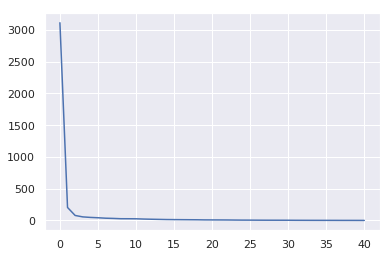

In [76]:
plt.plot(s**2)

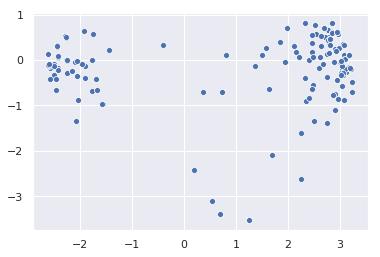

In [77]:
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1]);

In [80]:
vote2d = pd.DataFrame({
    'member': vote_pivot.index,
    'pc1': pcs[:, 0],
    'pc2': pcs[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

vote2d[vote2d['pc1'] < 0]['party'].value_counts()

Democrat    231
Name: party, dtype: int64

In [81]:
#top right only
vote2d.query('pc2 > -2 and pc1 > 0')['party'].value_counts()

Republican    194
Name: party, dtype: int64

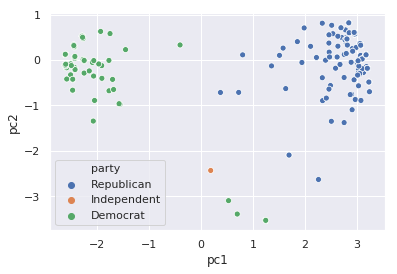

In [82]:
sns.scatterplot(x="pc1", y="pc2", hue="party", data = vote2d);

In [83]:
vote2d['pc1_jittered'] = vote2d['pc1'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])
vote2d['pc2_jittered'] = vote2d['pc2'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])

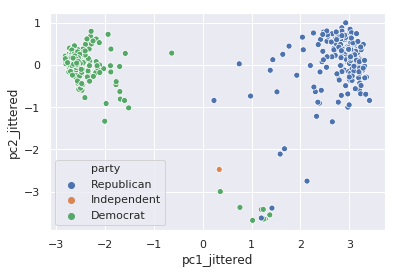

In [84]:
sns.scatterplot(x="pc1_jittered", y="pc2_jittered", hue="party", data = vote2d);

In [85]:
vote2d.head(5)

,member,pc1,pc2,leg_id,first,last,gender,state,chamber,party,birthday,pc1_jittered,pc2_jittered
0,A000055,3.061356,0.364191,A000055,Robert,Aderholt,M,AL,rep,Republican,1965-07-22,3.236672,0.419010
1,A000367,0.188870,-2.433565,A000367,Justin,Amash,M,MI,rep,Independent,1980-04-18,0.335760,-2.477060
2,A000369,2.844370,0.821619,A000369,Mark,Amodei,M,NV,rep,Republican,1958-06-12,2.881618,0.607080
3,A000370,-2.607536,0.127977,A000370,Alma,Adams,F,NC,rep,Democrat,1946-05-27,-2.651516,0.127991
4,A000371,-2.607536,0.127977,A000371,Pete,Aguilar,M,CA,rep,Democrat,1979-06-19,-2.529477,0.163449


In [86]:
vote2d[vote2d['pc1'] > 0]['party'].value_counts()

Republican     199
Democrat         8
Independent      1
Name: party, dtype: int64

In [87]:
vote2d[vote2d['pc2'] < -1]

,member,pc1,pc2,leg_id,first,last,gender,state,chamber,party,birthday,pc1_jittered,pc2_jittered
1,A000367,0.188870,-2.433565,A000367,Justin,Amash,M,MI,rep,Independent,1980-04-18,0.335760,-2.477060
6,A000374,1.247134,-3.533196,A000374,Ralph,Abraham,M,LA,rep,Republican,1954-09-16,1.416271,-3.392843
47,B001311,1.695651,-2.093912,B001311,Dan,Bishop,M,NC,rep,Republican,1964-07-01,1.584739,-2.111275
50,C000537,0.699636,-3.394179,C000537,James,Clyburn,M,SC,rep,Democrat,1940-07-21,0.760606,-3.377030
52,C000984,0.531789,-3.099044,C000984,Elijah,Cummings,M,MD,rep,Democrat,1951-01-18,0.357229,-3.000326
69,C001087,2.755060,-1.378193,C001087,Eric,Crawford,M,AR,rep,Republican,1966-01-22,2.654249,-1.346961
150,G000582,2.262007,-2.632452,G000582,Jenniffer,González-Colón,F,PR,rep,Republican,1976-08-05,2.135076,-2.752400
179,H001077,2.509474,-1.349023,H001077,Clay,Higgins,M,LA,rep,Republican,1961-08-24,2.330408,-1.215764
196,J000299,2.908823,-1.094618,J000299,Mike,Johnson,M,LA,rep,Republican,1972-01-30,2.972072,-0.998884
272,M001200,1.247134,-3.533196,M001200,A.,McEachin,M,VA,rep,Democrat,1961-10-10,1.372221,-3.554329


In [88]:
df = votes[votes['member'].isin(vote2d[vote2d['pc2'] < -1]['member'])]
df.groupby(['member', 'vote']).size()

member   vote      
A000367  No            31
         Yes           10
A000374  Not Voting    41
B001311  No            17
         Yes            7
C000537  No             1
         Not Voting    37
         Yes            3
C000984  No             4
         Not Voting    32
         Yes            5
C001087  No             6
         Not Voting    23
         Yes           12
G000582  Not Voting     1
         Yes            6
H001077  No            14
         Not Voting    15
         Yes           12
J000299  No            20
         Not Voting     7
         Yes           14
M001200  Not Voting    41
M001210  No            16
         Not Voting     1
         Yes            7
N000147  No             6
         Not Voting     1
P000197  Speaker       41
P000610  No             7
R000577  No            11
         Not Voting     8
         Yes           22
R000600  Not Voting     7
S001177  No             7
S001204  No             6
         Not Voting     1
dtype: int64

In [89]:
legs.query("leg_id == 'A000367'")

,leg_id,first,last,gender,state,chamber,party,birthday
33,A000367,Justin,Amash,M,MI,rep,Independent,1980-04-18


### Let's look at only people who have voted more than 15 times lately

In [90]:
votes.head(5)

,chamber,session,roll call,member,vote
0,House,1,555,A000374,Not Voting
1,House,1,555,A000370,Yes
2,House,1,555,A000055,No
3,House,1,555,A000371,Yes
4,House,1,555,A000372,No


In [91]:
num_yes_or_no_votes_per_member = votes.query("vote == 'Yes' or vote == 'No'").groupby("member").size()
num_yes_or_no_votes_per_member.head(5)

member
A000055    40
A000367    41
A000369    41
A000370    41
A000371    41
dtype: int64

In [92]:
vote_pivot_with_yes_no_count = vote_pivot.merge(num_yes_or_no_votes_per_member.to_frame(), left_index = True, right_index = True, how="outer", ).fillna(0)
vote_pivot_with_yes_no_count = vote_pivot_with_yes_no_count.rename(columns = {0: 'yes_no_count'})
vote_pivot_with_yes_no_count.head(5)

,515,516,517,518,519,520,521,522,523,524,...,547,548,549,550,551,552,553,554,555,yes_no_count
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,0,1,0,0,1,0,0,1,0,40.0
A000367,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,0,1,41.0
A000369,1,1,0,0,1,1,0,1,1,1,...,0,1,0,0,1,0,0,1,0,41.0
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,0,1,1,1,1,41.0
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,0,1,1,1,1,41.0


In [93]:
regulars = vote_pivot_with_yes_no_count.query('yes_no_count >= 30')
regulars = regulars.drop('yes_no_count', 1)
regulars.shape

(425, 41)

In [94]:
regulars_centered = regulars - np.mean(regulars, axis = 0)
regulars_centered.head(5)

,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,0.101176,-0.691765,-0.543529,-0.541176,0.023529,0.581176,-0.581176,0.625882,0.588235,0.550588,...,-0.541176,-0.545882,0.014118,-0.538824,-0.536471,0.529412,-0.538824,-0.555294,0.056471,-0.522353
A000367,-0.898824,-0.691765,-0.543529,-0.541176,-0.976471,-0.418824,-0.581176,-0.374118,-0.411765,-0.449412,...,-0.541176,0.454118,0.014118,0.461176,0.463529,-0.470588,0.461176,0.444706,-0.943529,0.477647
A000369,0.101176,0.308235,-0.543529,-0.541176,0.023529,0.581176,-0.581176,0.625882,0.588235,0.550588,...,-0.541176,-0.545882,0.014118,-0.538824,-0.536471,0.529412,-0.538824,-0.555294,0.056471,-0.522353
A000370,0.101176,0.308235,0.456471,0.458824,0.023529,-0.418824,0.418824,-0.374118,-0.411765,-0.449412,...,0.458824,0.454118,0.014118,0.461176,0.463529,-0.470588,0.461176,0.444706,0.056471,0.477647
A000371,0.101176,0.308235,0.456471,0.458824,0.023529,-0.418824,0.418824,-0.374118,-0.411765,-0.449412,...,0.458824,0.454118,0.014118,0.461176,0.463529,-0.470588,0.461176,0.444706,0.056471,0.477647


In [95]:
u, s, vt = np.linalg.svd(regulars_centered, full_matrices = False)

In [96]:
np.round(s**2 / sum(s**2), 2)

array([0.84, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

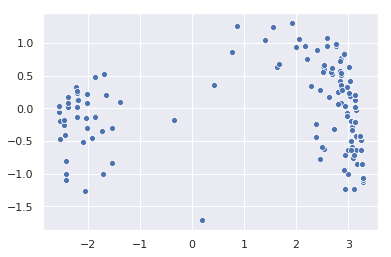

In [97]:
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1]);

In [98]:
vote2d = pd.DataFrame({
    'member': regulars_centered.index,
    'pc1': pcs[:, 0],
    'pc2': pcs[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

vote2d['pc1_jittered'] = vote2d['pc1'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])
vote2d['pc2_jittered'] = vote2d['pc2'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])

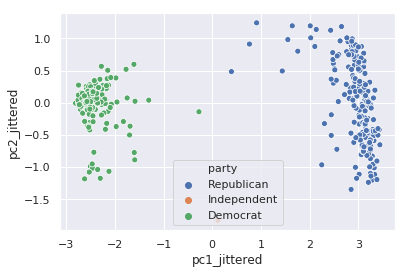

In [99]:
sns.scatterplot(x="pc1_jittered", y="pc2_jittered", hue="party", data = vote2d);

## Exploring $V^T$

We can also look at Vt directly to try to gain insight into why each component is as it is.

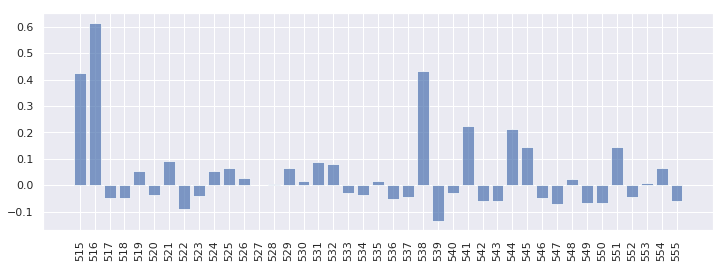

In [102]:
num_votes = vt.shape[1]
votes = regulars.columns

def plot_pc(k):
    plt.bar(votes, vt[k, :], alpha=0.7)
    plt.xticks(votes, rotation=90);

with plt.rc_context({"figure.figsize": (12, 4)}):
    #plot_pc(0)
    plot_pc(1)


Using SVD for PCA may lead to hard to interpret $V^T$ matrices for two reasons:
1. Each row tends to include many many attributes. What does it mean that the first PC is driven by this specific set of 30 votes?
2. Later rows (i.e. less important PCs) will be driven more by the orthogonality constraint than the data itself.

There are exist other methods for doing PCA, e.g. Sparse PCA, that will try to lead to an interpretable version of $V^T$.